In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.046 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [20]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

### Parsing

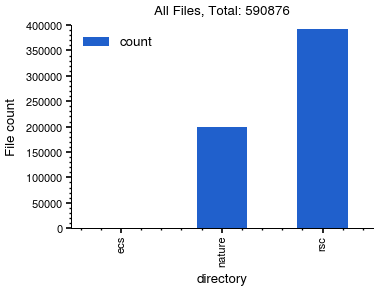

,directory,count
0,ecs,42
1,nature,198487
2,rsc,392347


In [42]:
df = execute("""
             SELECT directory, count(*) FROM paper_corpus pc
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='File count', title=f"All Files, Total: {total}")
plt.savefig('notebooks/files_per_directory.png', dpi=600)
plt.show()
df

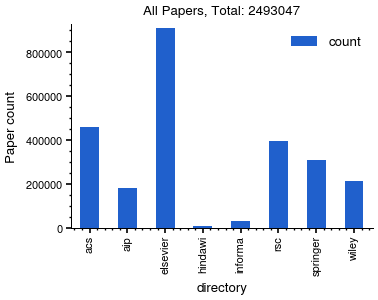

,directory,count
0,acs,457510
1,aip,177932
2,elsevier,907234
3,hindawi,6951
4,informa,27898
5,rsc,392346
6,springer,309847
7,wiley,213329


In [7]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"All Papers, Total: {total}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

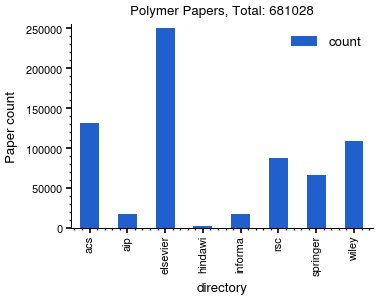

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa,17396
5,rsc,87429
6,springer,66532
7,wiley,108968


In [8]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total}")
plt.savefig('notebooks/polymer_papers_per_directory.png', dpi=600)
plt.show()
df

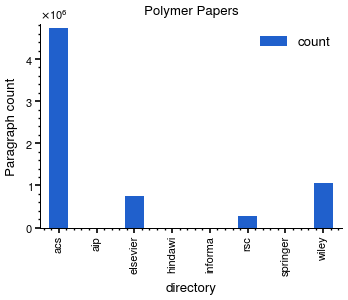

,directory,count
0,acs,4726853
1,aip,4
2,elsevier,759340
3,hindawi,74
4,informa,24
5,rsc,281216
6,springer,74
7,wiley,1048511


In [8]:
df = execute("""
             SELECT directory, count(*) FROM paper_texts pt
             -- only the polymer papers
             JOIN filtered_papers fp ON fp.doi = pt.doi 
             GROUP BY directory;
""")
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title="Polymer Papers")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

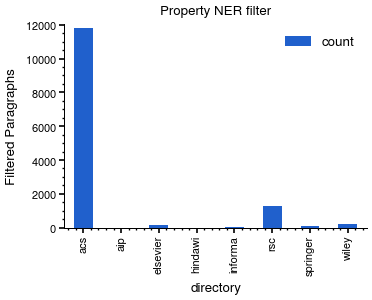

,directory,count
0,acs,11793
1,aip,2
2,elsevier,167
3,hindawi,2
4,informa,19
5,rsc,1275
6,springer,88
7,wiley,189


In [9]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_%'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = 'Property NER filter')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

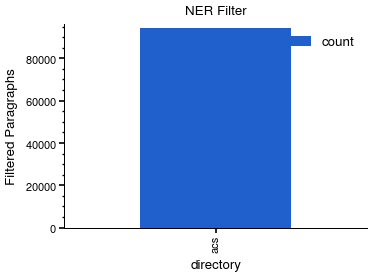

,directory,count
0,acs,94192


In [10]:
df = execute("""
    -- general ner filter
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_filter'
    GROUP BY pt.directory;
""")

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = 'NER Filter')
plt.savefig('notebooks/ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [11]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,81849


In [12]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,176323


In [13]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [14]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [36]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', label='Total: %d' %df.shape[0], ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace("/", "_")}.png', dpi=600)
    plt.show()

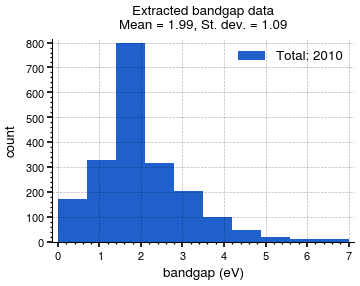

,doi,material,numeric_value,unit
0,10.1021/jp0208743,PbS,0.41,eV
1,10.1021/jp0208743,PbS,5.20,eV
2,10.1021/acs.jpclett.6b03063,p,1.70,eV
3,10.1021/acs.jpclett.6b03063,mnm,1.70,eV
4,10.1021/acs.jpclett.6b03063,p 1,1.70,eV
...,...,...,...,...
2005,10.1021/jacs.7b01170,PBDB-T,1.56,eV
2006,10.1021/jp910023d,F8T2,2.40,∼ eV
2007,10.1021/acsami.0c18599,NDI,1.40,. eV
2008,10.1021/acsami.0c18599,p­(C_{4} -T2),1.40,. eV


In [41]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap')
df

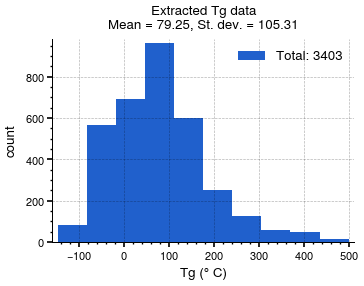

,doi,material,numeric_value,unit
0,10.1021/acs.molpharmaceut.9b00186,KTZ,21.85,+ / ° C
1,10.1021/acs.macromol.8b01325,PS,100.00,° C
2,10.1021/la020275n,poly(norbornene)s,9.90,° C
3,10.1021/ma951549z,P3HB,-50.00,° C
4,10.1021/acs.macromol.5b02788,F-PEK­(DPE),198.50,° C
...,...,...,...,...
3398,10.1021/acsami.6b05064,SAF-3-DMB,116.00,° C
3399,10.1021/acsami.6b05064,SAF-3-DMB,132.00,° C
3400,10.1021/cm010731d,PUOX,60.00,° C
3401,10.1021/ma9820265,"1,2,3,4-PI",-30.00,° C


In [38]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg')
df

In [40]:
# Make histograms for all properties.
# props = execute("select * from property_metadata")
# for prop in props.name:
#     df = extract_properties(prop)
#     if df is not None:
#         plot_histogram(df, prop)

In [20]:
postgres.disconnect()